# Imports

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container{max-width:90%!important;width:auto!important;}</style>"))

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm.notebook import trange

In [4]:
def show_img(im, ax=None, figsize=(8,8)):
    if not ax: _,ax = plt.subplots(1,1,figsize=figsize)
    if len(im.shape)==2: im = np.tile(im[:,:,None], 3) 
    ax.imshow(im[:,:,::-1]);
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    return ax

In [5]:
def show_imgs(ims, rows=1, figsize=(16,8)):
    _,ax = plt.subplots(rows, len(ims)//rows, figsize=figsize)
    [show_img(im,ax_) for im,ax_ in zip(ims,ax.flatten())]
    return ax

# HOG (Histograms of Oriented Gradients)

HOG is yet another type of descriptor which work particularly well for object detection tasks (e.g. detecting a car or a pedestrian in an image). The idea is that appearance of any object can be described with distribution of edge directions (i.e. *histogram* of *oriented gradients*). 

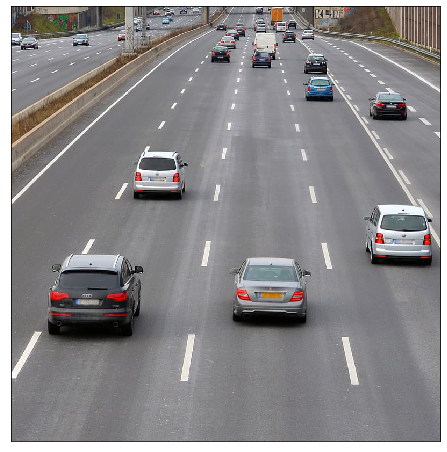

In [6]:
im = cv2.imread('05-files/cars.jpg')
show_img(im);

((128, 128, 3), (128, 128, 3))

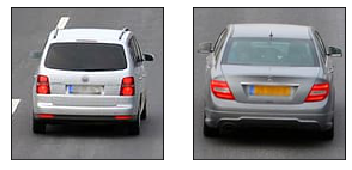

In [7]:
im_car1 = im[252:380, 210:338].copy()
im_car2 = cv2.resize(im[450:610, 402:562], (128,128))

_,ax = plt.subplots(1,2)
show_img(im_car1, ax[0]);
show_img(im_car2, ax[1]);

im_car1.shape, im_car2.shape

HOG can be used at various scales (image pyramid), but the aspect ratio of the patch is fixed once you choose it. In our case it is 1:1, for tall objects you can decide on for example 2:1, or whatever suits your application. 

## Gradients

Gradient calculation using the `Sobel` operator.

In [8]:
gradX = cv2.Sobel(im_car1, ddepth=cv2.CV_32F, dx=1, dy=0) # reveal vertical edges
gradY = cv2.Sobel(im_car1, ddepth=cv2.CV_32F, dx=0, dy=1) # reveal horizontal edges

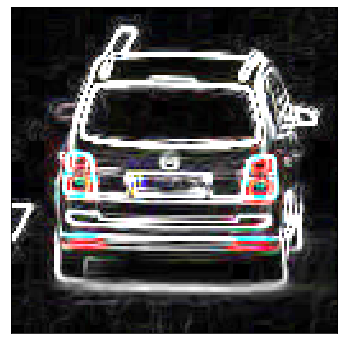

In [9]:
# gradient magnitude and angle/direction
grad = cv2.convertScaleAbs(np.sqrt(gradX**2 + gradY**2))
angles = np.mod(np.arctan(gradY/(gradX+1e-10)) * 180/np.pi + 180, 180)  # mod() for unsigned gradients 

show_img(grad, figsize=(6,6));

Gradients are high when intensity changes a lot (sharp edges and corners). For flat areas like the road, gradients are small.

At any location gradient magnitude is the maximum over the three colour channels. Gradient angle is the angle **corresponding to the maximum gradient**.

In [10]:
ix = np.argmax(grad, axis=2)

In [11]:
ix[30:40,30:40]

array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 1, 0, 2, 2, 2, 2],
       [0, 0, 0, 2, 0, 2, 2, 2, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 1, 1, 1],
       [0, 0, 1, 0, 1, 0, 0, 1, 1, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 1, 1]])

If I now want to get the angles corresponding to max gradients or the gradients themselves:

In [12]:
angles[:,:,ix].shape # this doesn't work!

(128, 128, 128, 128)

In [13]:
I,J = np.indices(ix.shape)
I,J

(array([[  0,   0,   0, ...,   0,   0,   0],
        [  1,   1,   1, ...,   1,   1,   1],
        [  2,   2,   2, ...,   2,   2,   2],
        ...,
        [125, 125, 125, ..., 125, 125, 125],
        [126, 126, 126, ..., 126, 126, 126],
        [127, 127, 127, ..., 127, 127, 127]]),
 array([[  0,   1,   2, ..., 125, 126, 127],
        [  0,   1,   2, ..., 125, 126, 127],
        [  0,   1,   2, ..., 125, 126, 127],
        ...,
        [  0,   1,   2, ..., 125, 126, 127],
        [  0,   1,   2, ..., 125, 126, 127],
        [  0,   1,   2, ..., 125, 126, 127]]))

In [17]:
angles[I,J,ix].shape

(128, 128)

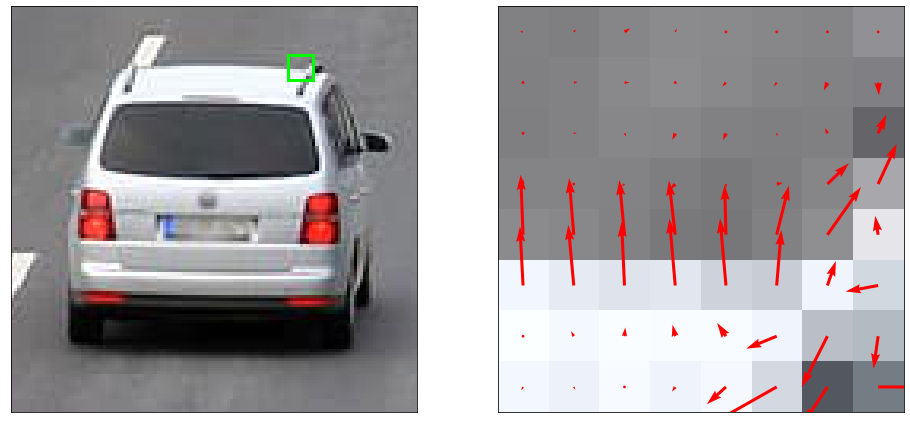

In [18]:
sr, sc = slice(15,23), slice(87,95)
ax = show_imgs((cv2.rectangle(im_car1.copy(), (sc.start,sr.start), (sc.stop,sr.stop), (0,255,0)), im_car1[sr,sc]))
ax[1].quiver(gradX[I,J,ix][sr,sc], gradY[I,J,ix][sr,sc], color='red');

## Histogram

We want a descriptor for each 8x8* patch. Note how this approach is different from SIFT/SURF where we would first look for keypopints and calculate descriptors for those.

\* this is what worked well in the paper that proposed HOG; other sizes are possible

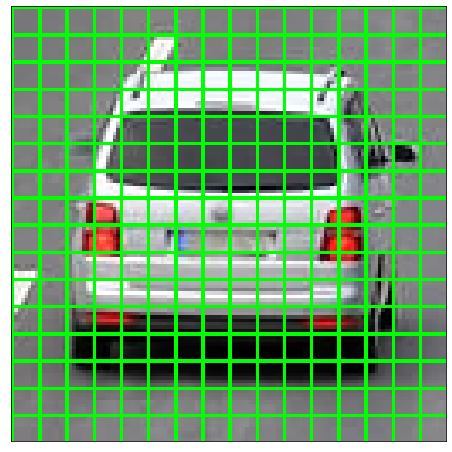

In [19]:
im_copy = im_car1.copy()
for x in range(im_copy.shape[1]//8):
    for y in range(im_copy.shape[0]//8):
        cv2.rectangle(im_copy, (x*8, y*8), ((x+1)*8, (y+1)*8), (0,255,0), 1)

ax = show_img(im_copy)

In [20]:
# max gradients and corresponding angles for the whole image
grad_mx = grad[I,J,ix]
angles_mx = angles[I,J,ix]

# max gradients and corresponding angles for the patch defined by sr,sc
grad_p = grad_mx[sr,sc]
angles_p = angles_mx[sr,sc]

grad_p, angles_p

(array([[ 26,  27,  51,  27,  22,  18,  22,  11],
        [ 11,  31,  38,  18,  42,  36,  68,  98],
        [ 11,  24,  28,  56,  58,  24,  46, 158],
        [ 42,  19,  29,  55,  31,  50, 232, 255],
        [255, 255, 255, 255, 255, 255, 255, 149],
        [255, 255, 255, 255, 255, 255, 201, 255],
        [ 24,  44,  68,  91, 124, 255, 255, 255],
        [ 30,  25,  19,  45, 200, 255, 255, 255]], dtype=uint8),
 array([[175.60129  ,  38.990997 ,  30.579224 ,  63.43495  , 146.30994  ,
           6.3401947, 158.1986   , 127.874985 ],
        [ 45.       ,   9.1623535,   0.       ,  83.65979  ,  46.90915  ,
          56.309937 ,  65.69545  ,  93.50353  ],
        [ 74.74487  ,   4.7636414, 117.47444  ,  67.0679   ,  66.54097  ,
          99.462326 , 113.19859  ,  66.515884 ],
        [ 92.72632  ,  98.972626 ,  36.46924  ,  47.93567  ,  91.84761  ,
          10.407715 ,  43.952026 ,  65.22485  ],
        [ 92.21204  ,  94.67742  ,  95.36415  ,  96.63876  ,  91.47637  ,
          76.0694  

Our histogram will have 9 bins (each `8x8x3` patch will be represented by 9 numbers which gives a *compact* representation), 20 degrees apart (i.e. at 0, 20, ... 160 degrees). 

Angles above 160 degrees contribute both to the last and first been (wrap around 180), proportionally.

In [21]:
bins = np.arange(-20,181,20)
bins

array([-20,   0,  20,  40,  60,  80, 100, 120, 140, 160, 180])

In [22]:
def hog_descr(grad_p, angles_p, debug=False):
    bin_cnts = np.zeros((11,))

    for g,a in zip(grad_p.flatten(),angles_p.flatten()):

        # which bin(s)?
        b1 = np.argwhere(a>bins).max()
        b2 = np.argwhere(a<bins).min()
        if debug: print(a,b1,b2,bins[b1],bins[b2])

        if b2-b1==2:
            bin_cnts[(b1+b2)//2] += g
        else:
            w2 = abs(bins[b1]-a) / (bins[b2]-bins[b1])
            w1 = abs(bins[b2]-a) / (bins[b2]-bins[b1])
            bin_cnts[b1] += w1*g
            bin_cnts[b2] += w2*g

    bin_cnts[1] += bin_cnts[-1]
    bin_cnts = bin_cnts[1:-1] # drop bins -20 and 180
    return bin_cnts

In [23]:
hog_descr(np.array([20,20,20]), np.array([20,50,165]), debug=True)

20 1 3 0 40
50 3 4 40 60
165 9 10 160 180


array([ 5., 20., 10., 10.,  0.,  0.,  0.,  0., 15.])

In [24]:
bin_cnts = hog_descr(grad_p, angles_p)

In [25]:
bin_cnts.sum(), grad_p.sum() # sanity check!

(7784.000000000001, 7784)

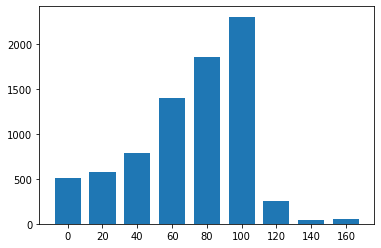

In [26]:
plt.bar(bins[1:-1], bin_cnts, width=15)
plt.xticks(bins[1:-1]);

In [27]:
# calculate HOG for the whole image
descr = np.zeros((grad.shape[1]//8, grad.shape[0]//8, 9))

for x in trange(grad.shape[1]//8):
    for y in range(grad.shape[0]//8):
        descr[y,x] = hog_descr(grad_mx[y*8:(y+1)*8, x*8:(x+1)*8], angles_mx[y*8:(y+1)*8, x*8:(x+1)*8])

### Normalisation 

Gradient magnitudes depend on lighting; if we changed the brightness of the image, the gradients will change as well - we want to counteract this by normalising the histograms. We could normalise each of the histograms individually but for better results we'll do it in `2x2` blocks (or `16x16` pixel regions).

In [ ]:
descr.shape

In [28]:
descr_norm = np.zeros_like(descr)
for x in range(descr.shape[1]-1):
    for y in range(descr.shape[0]-1):
        d = descr[y:y+2, x:x+2]
        descr_norm[y:y+2,x:x+2] += d / np.sqrt((d**2).sum())

The problem is that some descriptors are normalised multiple times!

In [30]:
dv = np.full(descr_norm.shape[:2], 4)
a = np.array([1] + (descr.shape[0]-2)*[2] + [1])
dv[0, :] = a
dv[-1,:] = a
dv[:, 0] = a
dv[:,-1] = a
dv

array([[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1],
       [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2],
       [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2],
       [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2],
       [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2],
       [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2],
       [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2],
       [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2],
       [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2],
       [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2],
       [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2],
       [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2],
       [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2],
       [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2],
       [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2],
       [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1]])

In [31]:
descr_norm /= dv[...,None]
descr_norm[:4,:4]

array([[[0.26967279, 0.02313375, 0.03065373, 0.07972787, 0.10021127,
         0.05751026, 0.02784062, 0.02196049, 0.        ],
        [0.31824941, 0.06705094, 0.10285551, 0.1684474 , 0.10315931,
         0.09071236, 0.07153202, 0.09161688, 0.14134329],
        [0.06014576, 0.        , 0.00240381, 0.08760564, 0.44069922,
         0.29480411, 0.06270326, 0.06854521, 0.04721022],
        [0.25097808, 0.16001588, 0.03281745, 0.02794901, 0.02404012,
         0.0462343 , 0.11867702, 0.04998125, 0.06850205]],

       [[0.18762102, 0.        , 0.07035788, 0.02345263, 0.09381051,
         0.09381051, 0.        , 0.        , 0.        ],
        [0.48290107, 0.10278747, 0.19093142, 0.06430197, 0.05738754,
         0.06108484, 0.04890794, 0.03847696, 0.15517092],
        [0.07468795, 0.13305938, 0.10634502, 0.08797597, 0.20076055,
         0.18376253, 0.03090213, 0.06358398, 0.05055706],
        [0.21611534, 0.19837441, 0.06285785, 0.03024802, 0.00574115,
         0.        , 0.03241776, 0.12185

## HOG in scikit-image

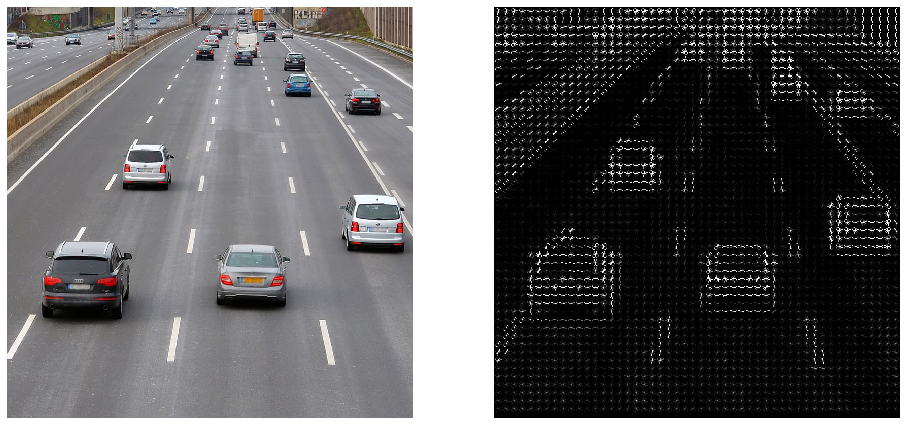

In [33]:
from skimage.feature import hog
from skimage import data, exposure

fd, hog_image = hog(im, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True, multichannel=True)
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

_, ax = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)

ax[0].axis('off'); ax[0].imshow(im[:,:,::-1]);
ax[1].axis('off'); ax[1].imshow(hog_image_rescaled, cmap=plt.cm.gray);

# HOG-based classifier

In [34]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

In [35]:
# one of the many ways of downloading a standard dataset (takes about 30s to run)
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [36]:
X.shape

(70000, 784)

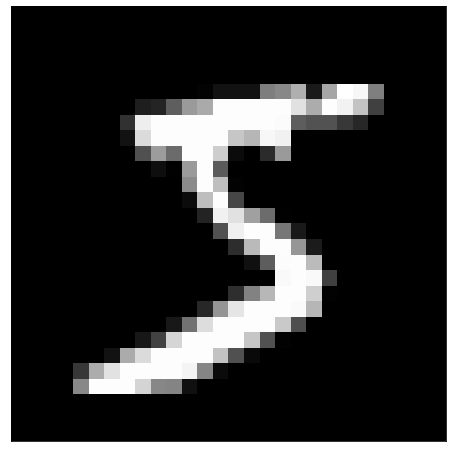

In [37]:
show_img(X[0].reshape(28,28).astype(np.int))

In [38]:
perm = np.random.permutation(X.shape[0])
Xtr, ytr = X[perm[:1000]], y[perm[:1000]]
Xte, yte = X[perm[-1000:]], y[perm[-1000:]]

In [39]:
scaler = StandardScaler().fit(Xtr)
clf = LogisticRegression(solver='saga', tol=0.01)
clf.fit(scaler.transform(Xtr), ytr)
score = clf.score(scaler.transform(Xte), yte)
score

0.871

In [41]:
Xtrf = [hog(x.reshape(28,28).astype(np.int), orientations=9, pixels_per_cell=(7,7), cells_per_block=(2,2), transform_sqrt=True, block_norm='L1') for x in Xtr]
Xtef = [hog(x.reshape(28,28).astype(np.int), orientations=9, pixels_per_cell=(7,7), cells_per_block=(2,2), transform_sqrt=True, block_norm='L1') for x in Xte]

In [42]:
scaler = StandardScaler().fit(Xtrf)
clf = LogisticRegression(solver='saga', tol=0.01)
clf.fit(scaler.transform(Xtrf), ytr)
score = clf.score(scaler.transform(Xtef), yte)
score

0.93

# Homework

## For labs

HOG-based template matching